## Package Loading

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tol_colors as tc  
import skimage.io as io
import skimage.transform as trans
import tensorflow as tf
import pandas as pd

from os.path import join
from tensorflow.keras import backend as keras
from keras.models import load_model
from skimage import io, morphology
from skimage.color import rgb2gray

## Package for CNN
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

## Load the SEM Images 

In [2]:
datadir = '../'

#Set the subdirectory containing images to be processed
imagedir = join(datadir,'Github code', 'PATH WHERE TO FIND THE IMAGES')


# Savefig options:
kwfig = {'dpi': 400, 'bbox_inches': 'tight', 'pad_inches': 0}

figdir = join(datadir,'Github code','PATH WHERE TO SAVE THE IMAGES')

In [3]:
#List of available images

#Image to process (put '*' if you want to process all the images of the dataset)
prefix = '*' #to process all the images

list_image = [file for file in glob.glob(join(imagedir,'*.tif'))]
print(list_image)
len(list_image)

['../Github code/PATH WHERE TO FIND THE IMAGES/DiploMayotte18-9.2-012.tif', '../Github code/PATH WHERE TO FIND THE IMAGES/PoritesMayotte18_14.1-080.tif', '../Github code/PATH WHERE TO FIND THE IMAGES/DiploMayotte18-7.2-077.tif', '../Github code/PATH WHERE TO FIND THE IMAGES/PorReunion15_12-1-006.tif']


4

## Load the CNN

In [4]:
cnndir = join(datadir, 'Github code', 'PATH WHERE TO FIND THE CNN')
#netname = 'CNN-Diplo.h5'
#netname = 'CNN-Porites.h5'
netname = 'CNN-Multi_coral.h5'

## Load the SEM dataset to be process

In [5]:
#Load SEM Images

image_arr = []

for name in list_image:
    img = io.imread(name)
    image_arr.append(img)  

/var/folders/qh/w496k49s21gbv12yhbj2_5kh0000gn/T/ipykernel_10612/3477819239.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_arr_gray = [rgb2gray(img) for img in image_arr]
/var/folders/qh/w496k49s21gbv12yhbj2_5kh0000gn/T/ipykernel_10612/3477819239.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


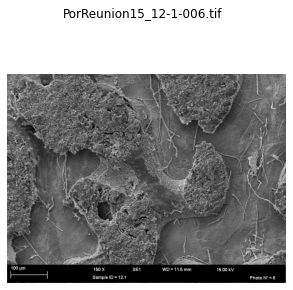

In [6]:
# Images Preprocessing
# Normalize SEM images between 0 and 1 for grayscale

image_arr_gray = [rgb2gray(img) for img in image_arr]
image_arr_norm = []
for img in image_arr_gray:
    if img.max()>1:
        image_arr_norm.append(img/255.)
    else:
        image_arr_norm.append(img)
        
#Show an example of a SEM image
iex = 3
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(image_arr_norm[iex],cmap='gray', clim=(0,1))
ax.axis('off')
fig.suptitle(os.path.basename(list_image[iex]))
fig.show()

Text(0.5, 0.98, 'PorReunion15_12-1-006.tif')

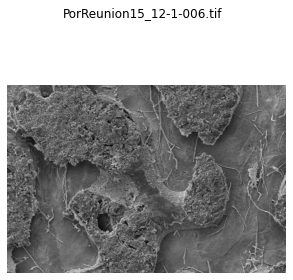

In [7]:
# Removing of the caption below the SEM images

ylim = 690 #Localisation of the legend on the image
image_arr_cut = [img[:ylim,:] for img in image_arr_norm]


#Show an example
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(image_arr_cut[iex],cmap='gray', clim=(0,1))
ax.axis('off')

fig.suptitle(os.path.basename(list_image[iex]))

## Images Extraction

In [8]:
#Size of the extracted image
im_size = (256,256)

#Full image size
SY, SX = image_arr_cut[0].shape

sizey, sizex = im_size
ny, nx = SY//sizey+1, SX//sizex
#Note +1 because we add an overlaped image from below

In [9]:
# Formatting of the SEM images to work with keras: 12 little SEM

input_image = np.zeros((ny, nx, len(image_arr_cut), sizey, sizex, 1))

for i in range(len(image_arr_cut)):
    for ix in range(nx):
        for iy in range(ny-1):
            #Input image:
            input_image[iy, ix, i, :, :, 0] =\
            image_arr_cut[i][sizey*iy:sizey*(iy+1),sizex*ix:sizex*(ix+1)]
            
        #Add the image starting from the bottom
        input_image[ny-1,ix,i, :, :, 0] =\
        image_arr_cut[i][SY-sizey:,sizex*ix:sizex*(ix+1)]

X = input_image.reshape(-1,sizey,sizex,1) 

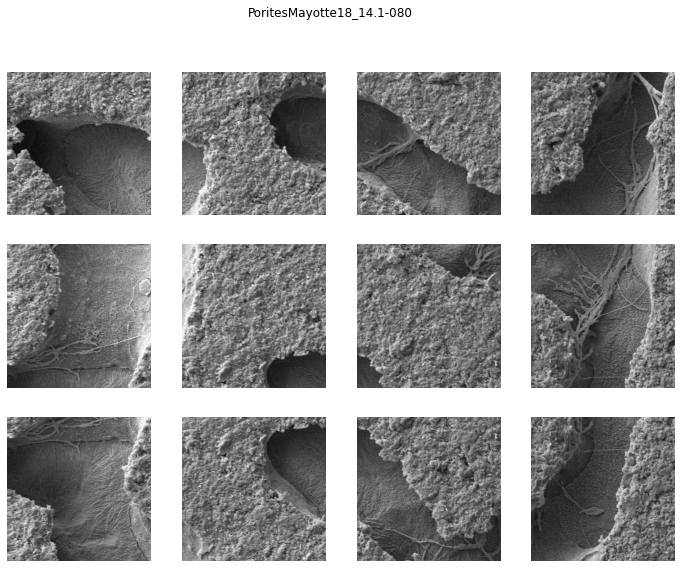

In [11]:
# Example of the first SEM image
i = 1
fig1, ax1 = plt.subplots(ny,nx, sharex='all', sharey='all', figsize=(3*nx,3*ny))

for iy in range(ny):
    for ix in range(nx):
        name = os.path.splitext(os.path.basename(list_image[i]))[0]
        
        ax1[iy,ix].imshow(input_image[iy, ix, i, :, :, 0], cmap='gray', clim=(0,1))
        ax1[iy,ix].axis('off')
        fig1.suptitle(name)
        

## CNN Estimations

In [12]:
cnn = load_model(os.path.join(cnndir,netname),compile = False)

2023-10-18 14:55:23.991037: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
ypredict = cnn.predict(X)

2023-10-18 14:55:25.030721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [14]:
ypredict_label = np.argmax(ypredict, axis=-1)
probmax= np.max(ypredict, axis=-1)

In [15]:
output = ypredict.reshape(ny, nx, len(image_arr_cut), sizex, sizey, 3)

In [16]:
## Reassembling of the original SEM image

loutput= []

for i in range(len(image_arr_cut)):
    img = np.zeros((SY, SX,3)) #big image  
    Nim = np.zeros((SY,SX,1)) #used to compute the mean
    for ix in range(nx):
        for iy in range(ny-1):
            img[sizey*iy:sizey*(iy+1),sizex*ix:sizex*(ix+1)] += output[iy, ix, i, :, :, :]
            Nim[sizey*iy:sizey*(iy+1),sizex*ix:sizex*(ix+1)] += 1
            
         #Add the image starting from the bottom
        img[SY-sizey:,sizex*ix:sizex*(ix+1)] += output[ny-1,ix, i, :, :, :]
        Nim[SY-sizey:,sizex*ix:sizex*(ix+1)] +=1
    img /= Nim
    loutput.append(img)

In [17]:
output_label = [np.argmax(img, axis=-1) for img in loutput]
output_proba = [np.max(img, axis=-1) for img in loutput]

## Only to do when using CNN-Diplo

In [ ]:
output_label = np.array([np.argmax(img, axis=-1) for img in loutput])
output_proba = [np.max(img, axis=-1) for img in loutput]

In [ ]:
## Invert class "resin and skeleton" to be displayed same as CNN-Porites and CNN-Multi

mask1 = output_label == 1
mask2 = output_label == 2

output_label[mask1] = 2
output_label[mask2] = 1

## Showing an SEM

(-0.5, 1023.5, 689.5, -0.5)

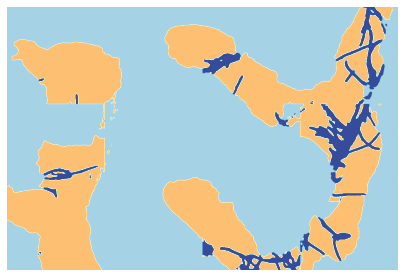

In [18]:
iex = 1

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.imshow(output_label[iex], cmap=tc.tol_cmap('sunset'),clim=(0,3))
ax1.axis('off')

## Saving of SEM images

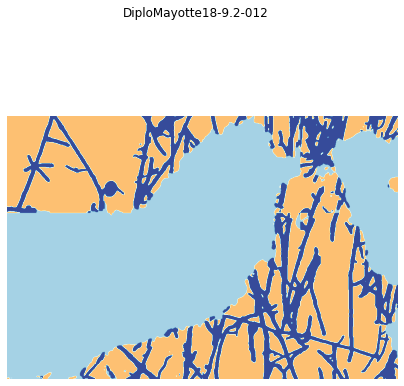

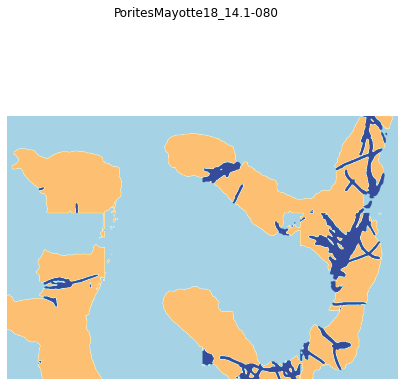

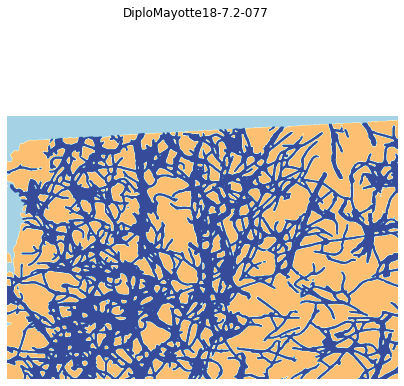

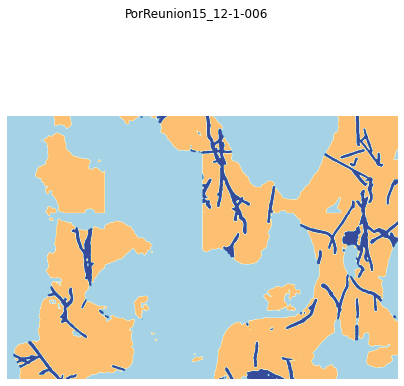

In [19]:
for iex in range(len(output_label)):
    filename = os.path.basename(list_image[iex])
    basename  = os.path.splitext(filename)[0]

    fig1, ax1 = plt.subplots(figsize=(7,7))
    ax1.imshow(output_label[iex],cmap=tc.tol_cmap('sunset'),clim=(0,3))
    ax1.axis('off')
    fig1.suptitle(basename)
    fig1.savefig(os.path.join(figdir,basename+'_label.png'))

## Define the Sheet for abundance values

In [20]:
#Making the spreadsheet file
columns = ['N_microboring_traces',
           'N_resin',
           'N_skeleton',
           'prop_microboring_traces',
           'prop_resin',
           'prop_skeleton']


D = {c:np.zeros(len(loutput)) for c in columns}
D['name'] = np.array([str(os.path.basename(img)) for img in list_image])

In [21]:
proba_threshold = 0.9
for i, (img, proba) in enumerate(zip(output_label, output_proba)):
    D['N_microboring_traces'][i] = np.sum(img==0)
    D['N_resin'][i] = np.sum(img==1)
    D['N_skeleton'][i] = np.sum(img==2)
  
    D['prop_microboring_traces'][i] = D['N_microboring_traces'][i] / (D['N_skeleton'][i]+D['N_microboring_traces'][i])
    mask = proba > proba_threshold

    D['prop_resin'][i] = D['N_resin'][i] / (D['N_skeleton'][i]+D['N_microboring_traces'][i]+D['N_resin'][i])
    mask = proba > proba_threshold    
    
    D['prop_skeleton'][i] = D['N_skeleton'][i] / (D['N_skeleton'][i]+D['N_microboring_traces'][i]+D['N_resin'][i])
    mask = proba > proba_threshold

## Export to Excel/csv Format with values

In [22]:
df = pd.DataFrame(D, columns=['name']+columns)

In [23]:
df.to_excel(os.path.join(figdir,'NAME OF THE FILE.xlsx'))
#df.to_csv(os.path.join(figdir,'NAME OF THE FILE.csv'))